In [1]:
import numpy as np
import cv2
import scipy.optimize
import os
import itertools
import gtsam
import gtsam.utils.plot
import matplotlib.pyplot as plt

import utils

In [2]:
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
image_dir = 'data/29_images/'

image_list = []

for image_file_name in sorted(os.listdir(image_dir)):

    image = cv2.imread(image_dir+image_file_name,
                       cv2.IMREAD_GRAYSCALE)
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    image_list.append(image)

image_height, image_width = image_list[0].shape[:2]

camera_matrix = np.array([[1, 0, image_width/2],
                          [0, 1, image_height/2],
                          [0, 0, 1]])

In [4]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((image_height, image_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 2, 255, -1)

    return non_max_suppression_mask

In [5]:
def norm_keypoints(keypoints):
    for keypoint in keypoints:
        keypoint.pt = tuple(np.linalg.inv(camera_matrix).dot(
            np.append(keypoint.pt, 1).T)[:-1].T)

In [6]:
sift = cv2.SIFT_create(nfeatures=4000,
                                   nOctaveLayers=12,
                                   contrastThreshold=0.025,
                                   sigma=1.5)

keypoints_list = []
descriptors_list = []

for image in image_list:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    non_max_suppression_mask = get_non_max_suppression_mask(keypoints)
    keypoints = np.array(keypoints)[non_max_suppression_mask]
    descriptors = np.array(descriptors)[non_max_suppression_mask]

    norm_keypoints(keypoints)

    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

In [7]:
bf_matcher = cv2.BFMatcher(cv2.NORM_L2)


def get_match_points(src_keypoints, src_descriptors, dst_keypoints, dst_descriptors):

    matches = bf_matcher.knnMatch(src_descriptors, dst_descriptors, k=2)
    cross_matches = bf_matcher.match(dst_descriptors, src_descriptors)

    cross_match_dict = {}
    for cross_match in cross_matches:
        cross_match_dict[cross_match.trainIdx] = cross_match.queryIdx

    src_points = []
    dst_points = []

    for match_1, match_2 in matches:
        if match_1.queryIdx in cross_match_dict and cross_match_dict[match_1.queryIdx] == match_1.trainIdx and match_1.distance < 0.75*match_2.distance:
            src_points.append(src_keypoints[match_1.queryIdx].pt)
            dst_points.append(dst_keypoints[match_1.trainIdx].pt)
    
    return np.array(src_points), np.array(dst_points)

In [8]:
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)]))

initial = gtsam.Values()

In [9]:
def get_match_points_from_dict(src_index, dst_index):
    if (src_index, dst_index) in match_dict:
        return match_dict[src_index, dst_index]
    else:
        src_points, des_points = get_match_points(keypoints_list[src_index],
                                                  descriptors_list[src_index],
                                                  keypoints_list[dst_index],
                                                  descriptors_list[dst_index])
        match_dict[src_index, dst_index] = src_points, des_points
                
        return src_points, des_points

In [10]:
def get_affine_matrix_noise(src_points, dst_points, check=False):

    if len(src_points) < 4:
        return None

    affine_matrix, ransac_mask = cv2.estimateAffinePartial2D(
        src_points,dst_points)

    match_count = np.count_nonzero(ransac_mask)

    if check and match_count < 3:
        return None

    scale = np.sqrt(affine_matrix[0, 0]**2+affine_matrix[1, 0]**2)

    affine_matrix[:2, :2] /= scale

    diag_noise = 1000*match_count**-2*np.array([1, 1, np.deg2rad(1)])

    gtsam_noise = gtsam.noiseModel.Diagonal.Sigmas(diag_noise)

    return np.linalg.inv(np.vstack((affine_matrix, [0, 0, 1]))), gtsam_noise

In [11]:
def get_gtsam_pose2(affine_matrix):
    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                       np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))

In [12]:
match_dict = {}

total_affine_matrix = np.eye(3)

initial.insert(0, gtsam.Pose2())

for src_index in range(len(image_list)-1):

    dst_index = src_index + 1

    src_points, des_points = get_match_points_from_dict(src_index, dst_index)

    affine_matrix, gtsam_noise = get_affine_matrix_noise(
        src_points, des_points)

    total_affine_matrix = affine_matrix.dot(total_affine_matrix)

    initial.insert(dst_index, get_gtsam_pose2(total_affine_matrix))

In [13]:
def check_overlap(pose_1, pose_2):
    return cv2.norm(pose_1.translation()-pose_2.translation()) < image_width

In [14]:
def build_graph(values):

    graph = gtsam.NonlinearFactorGraph()

    graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(
        image_width/2, image_height/2, 0), prior_noise))

    for src_index, dst_index in itertools.combinations(range(len(image_list)), 2):

        if src_index + 1 == dst_index:

            src_points, des_points = get_match_points_from_dict(
                src_index, dst_index)

            affine_matrix_noise = get_affine_matrix_noise(
                src_points, des_points)

            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               get_gtsam_pose2(affine_matrix_noise[0]), affine_matrix_noise[1]))

        elif check_overlap(values.atPose2(src_index), values.atPose2(dst_index)):

            src_points, des_points = get_match_points_from_dict(
                src_index, dst_index)

            affine_matrix_noise = get_affine_matrix_noise(
                src_points, des_points, check=True)

            if affine_matrix_noise is not None:
                graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                                   get_gtsam_pose2(affine_matrix_noise[0]), affine_matrix_noise[1]))

    return graph

In [15]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

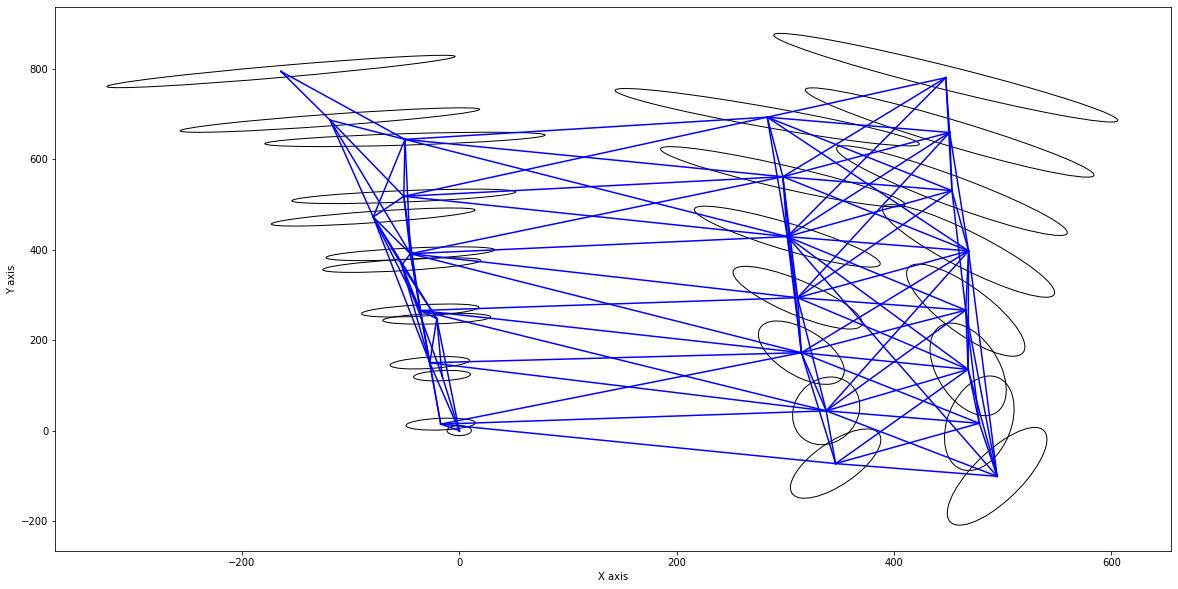

In [16]:
graph = build_graph(initial)
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

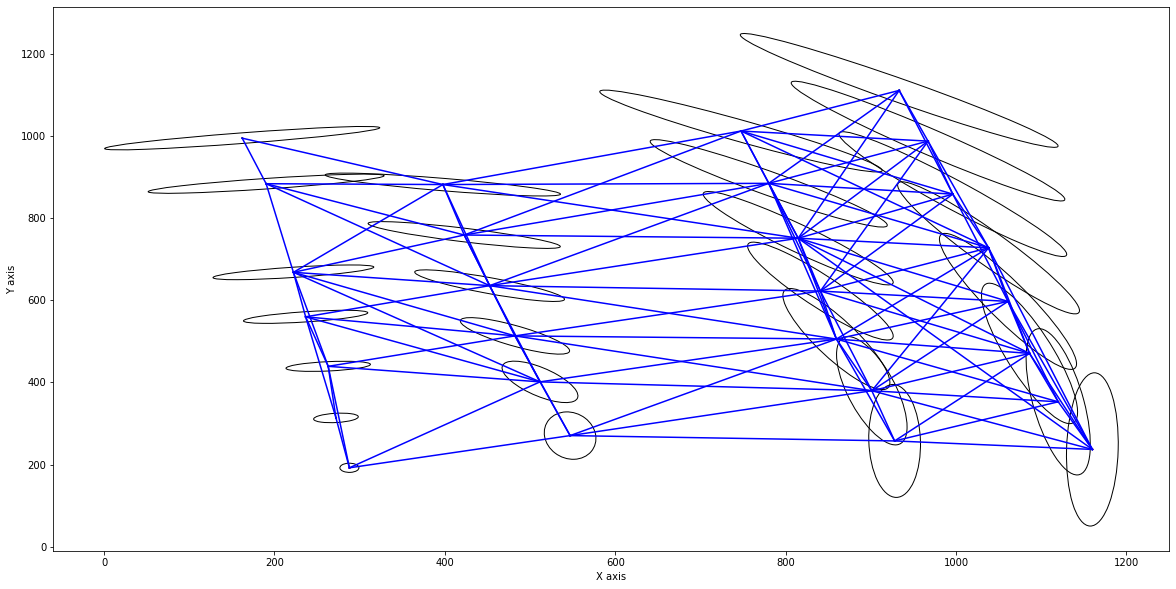

In [17]:
graph = build_graph(initial)
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

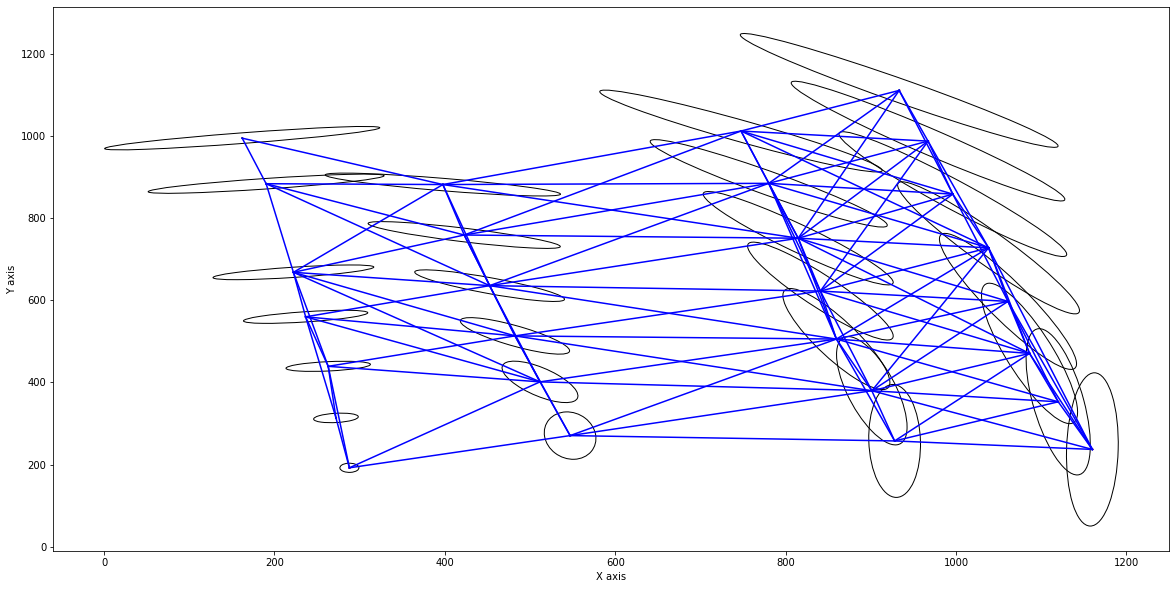

In [18]:
graph = build_graph(initial)
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [19]:
poses = gtsam.utilities.allPose2s(initial)

affine_matrix_list = []

for index in range(len(image_list)):

    pose = poses.atPose2(index)

    affine_matrix = pose.matrix()

    translation_matrix = np.eye(3)

    translation_matrix[:2, 2] -= np.array([image_width/2, image_height/2]).T

    affine_matrix_list.append(affine_matrix.dot(translation_matrix))

In [20]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [21]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, image_height - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, image_height - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [22]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0]), np.uint8)

    for homography_matrix, image in zip(homography_matrix_list, image_list):

        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)

        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]

    return stitch_image

<IPython.core.display.Javascript object>


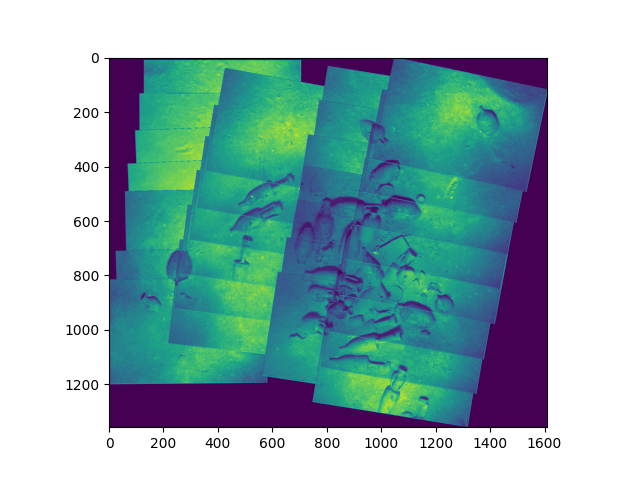

In [23]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, image_list, stitch_image_size, offset_affine_matrix)

%matplotlib notebook
plt.imshow(stitch_image)
plt.show()